# French Road Accident Data - Preprocessing Pipeline

This notebook processes French BAAC accident data for **multi-target prediction**.

## 🎯 Objectives
1. Load and merge accident data (caracteristiques + usagers)
2. Identify targets: **col** (collision type) and **max_severity** (gravity)
3. Select features based on correlation with BOTH targets
4. Detect outliers (valeurs aberrantes)
5. Clean data based on outlier analysis
6. Engineer time-based features
7. Encode categorical variables
8. Export cleaned data for modeling and dashboard

## 📊 Workflow
```
Raw Data → Load → Merge → Target Analysis → Feature Selection → 
Outlier Detection → Cleaning → Feature Engineering → Encoding → Export
```

## 📁 Outputs
- `data/cleaned_accidents.csv` - For Streamlit dashboard
- `data/model_ready.csv` - For machine learning models


---
## 1. Setup and Imports


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


---
## 2. Data Loading

Load accident characteristics and user/victim data from multiple years.


In [25]:
INPUT_DIR = 'data'

def load_csv_with_encoding(filepath: str) -> pd.DataFrame:
    """Load CSV with automatic encoding and delimiter detection."""
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    delimiters = [',', ';', '\t']
    
    for encoding in encodings:
        for delimiter in delimiters:
            try:
                df = pd.read_csv(filepath, encoding=encoding, sep=delimiter,
                                on_bad_lines='skip', engine='python')
                if len(df.columns) > 1:
                    return df
            except:
                continue
    raise ValueError(f"Could not load {filepath}")

def discover_csv_files(input_dir: str) -> dict:
    """Find and pair caracteristiques and usagers files."""
    if not os.path.exists(input_dir):
        return {'paired': [], 'standalone': []}
    
    files = os.listdir(input_dir)
    carac_files = [f for f in files if 'caract' in f.lower() and f.endswith('.csv')]
    usagers_files = [f for f in files if 'usager' in f.lower() and f.endswith('.csv')]
    
    paired = []
    for carac_file in carac_files:
        # Extract year/identifier
        identifier = carac_file.replace('caracteristiques', '').replace('caract', '').replace('.csv', '').strip('-_')
        # Find matching usagers file
        matching = [u for u in usagers_files if identifier in u or (not identifier and 'usagers.csv' == u)]
        
        if matching:
            carac_path = os.path.join(input_dir, carac_file)
            usagers_path = os.path.join(input_dir, matching[0])
            paired.append((carac_path, usagers_path, identifier or 'default'))
            usagers_files.remove(matching[0])
    
    return {'paired': paired}

def load_all_datasets(input_dir: str) -> tuple:
    """Load and combine all CSV files."""
    discovered = discover_csv_files(input_dir)
    
    print(f"Found {len(discovered['paired'])} paired file sets")
    
    carac_dfs = []
    usagers_dfs = []
    
    for carac_path, usagers_path, identifier in discovered['paired']:
        print(f"  Loading {identifier}...")
        carac_df = load_csv_with_encoding(carac_path)
        usagers_df = load_csv_with_encoding(usagers_path)
        
        carac_df['source_file'] = identifier
        usagers_df['source_file'] = identifier
        
        carac_dfs.append(carac_df)
        usagers_dfs.append(usagers_df)
    
    combined_carac = pd.concat(carac_dfs, ignore_index=True)
    combined_usagers = pd.concat(usagers_dfs, ignore_index=True)
    
    return combined_carac, combined_usagers

# Load data
print("="*70)
print("LOADING DATA")
print("="*70)
carac_df, usagers_df = load_all_datasets(INPUT_DIR)

print(f"\n✓ Caracteristiques: {len(carac_df):,} rows, {carac_df.shape[1]} columns")
print(f"✓ Usagers: {len(usagers_df):,} rows, {usagers_df.shape[1]} columns")

LOADING DATA
Found 6 paired file sets
  Loading 2023...
  Loading 2024...
  Loading 2018...
  Loading 2019...
  Loading 2020...
  Loading 2005-2017...

✓ Caracteristiques: 1,099,868 rows, 18 columns
✓ Usagers: 2,465,481 rows, 19 columns


---
## 3. Data Merging

Merge accident characteristics with aggregated user statistics.
We aggregate user-level data to accident-level to create our targets.


In [26]:
def merge_datasets(carac_df: pd.DataFrame, usagers_df: pd.DataFrame) -> pd.DataFrame:
    """Merge datasets and create target variables."""
    # Aggregate user data to accident level
    user_agg = usagers_df.groupby('Num_Acc').agg(
        num_users=('Num_Acc', 'count'),
        num_killed=('grav', lambda x: (x == 2).sum()),
        num_hospitalized=('grav', lambda x: (x == 3).sum()),
        num_light_injury=('grav', lambda x: (x == 4).sum()),
        max_severity=('grav', 'min')  # Lower = more severe (2=killed is worst)
    ).reset_index()
    
    # Merge with accident characteristics
    merged_df = carac_df.merge(user_agg, on='Num_Acc', how='left')
    
    return merged_df

print("="*70)
print("MERGING DATASETS")
print("="*70)
merged_df = merge_datasets(carac_df, usagers_df)

print(f"\n✓ Merged dataset: {len(merged_df):,} rows, {merged_df.shape[1]} columns")
print(f"\nColumns: {list(merged_df.columns)}")

MERGING DATASETS

✓ Merged dataset: 1,099,868 rows, 23 columns

Columns: ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long', 'source_file', 'gps', 'Unnamed: 0', 'num_users', 'num_killed', 'num_hospitalized', 'num_light_injury', 'max_severity']


---
## 4. Target Identification and Analysis

Our two targets for multi-target prediction:
- **col**: Collision type (7 classes)
- **max_severity**: Gravity/severity (4 classes)


TARGET ANALYSIS

[TARGET 1] Collision Type (col)
----------------------------------------------------------------------
Classes: [np.float64(-1.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]
Distribution:
col
-1.0      1536
 1.0    108613
 2.0    131186
 3.0    317922
 4.0     35396
 5.0     35106
 6.0    358303
 7.0    111787
Name: count, dtype: int64
Missing values: 19

[TARGET 2] Severity (max_severity)
----------------------------------------------------------------------
Classes: [np.int64(-1), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Distribution:
max_severity
-1       116
 1    777247
 2     32005
 3    138848
 4    151652
Name: count, dtype: int64
Missing values: 0


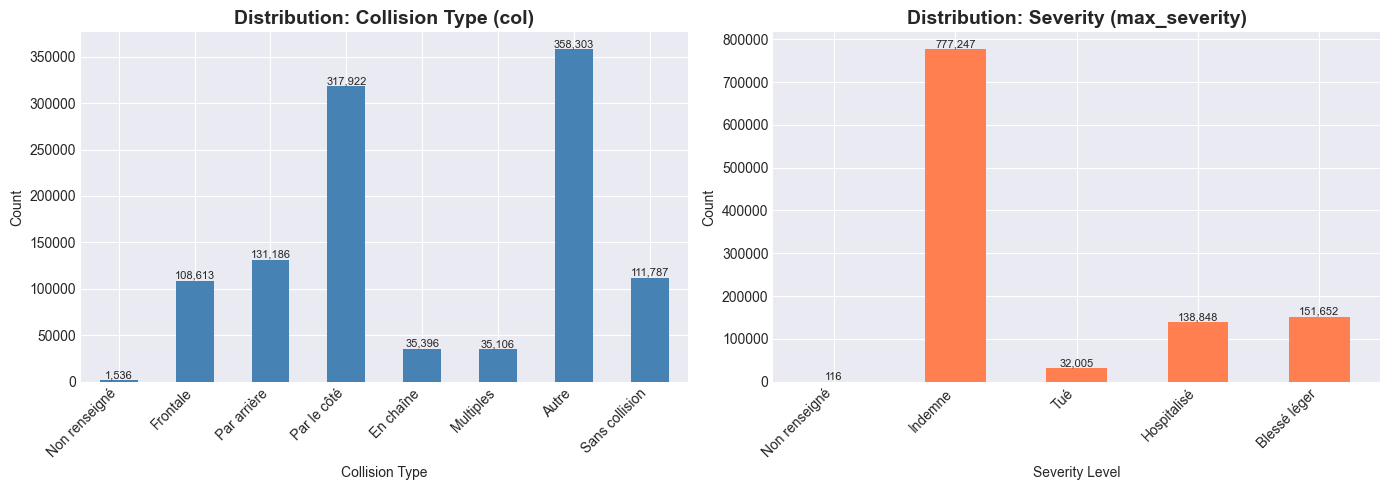

In [27]:
print("="*70)
print("TARGET ANALYSIS")
print("="*70)

# Target 1: Collision type (col)
print("\n[TARGET 1] Collision Type (col)")
print("-"*70)
col_counts = merged_df['col'].value_counts().sort_index()
print(f"Classes: {sorted(merged_df['col'].dropna().unique())}")
print(f"Distribution:\n{col_counts}")
print(f"Missing values: {merged_df['col'].isna().sum():,}")

# Collision type labels
COL_LABELS = {
    1: 'Frontale', 2: 'Par arrière', 3: 'Par le côté',
    4: 'En chaîne', 5: 'Multiples', 6: 'Autre', 7: 'Sans collision',
    -1: 'Non renseigné'
}

# Target 2: Severity (max_severity)
print("\n[TARGET 2] Severity (max_severity)")
print("-"*70)
sev_counts = merged_df['max_severity'].value_counts().sort_index()
print(f"Classes: {sorted(merged_df['max_severity'].dropna().unique())}")
print(f"Distribution:\n{sev_counts}")
print(f"Missing values: {merged_df['max_severity'].isna().sum():,}")

# Severity labels
SEV_LABELS = {
    1: 'Indemne', 2: 'Tué', 3: 'Hospitalisé', 4: 'Blessé léger',
    -1: 'Non renseigné'
}

# Visualize targets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot collision type
ax = axes[0]
col_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Distribution: Collision Type (col)', fontsize=14, fontweight='bold')
ax.set_xlabel('Collision Type')
ax.set_ylabel('Count')
# Fix: Handle -1 values properly
labels = []
for x in ax.get_xticklabels():
    try:
        code = int(float(x.get_text()))
        labels.append(COL_LABELS.get(code, str(code)))
    except:
        labels.append(x.get_text())
ax.set_xticklabels(labels, rotation=45, ha='right')
for i, v in enumerate(col_counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

# Plot severity
ax = axes[1]
sev_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Distribution: Severity (max_severity)', fontsize=14, fontweight='bold')
ax.set_xlabel('Severity Level')
ax.set_ylabel('Count')
# Fix: Handle -1 values properly
labels = []
for x in ax.get_xticklabels():
    try:
        code = int(float(x.get_text()))
        labels.append(SEV_LABELS.get(code, str(code)))
    except:
        labels.append(x.get_text())
ax.set_xticklabels(labels, rotation=45, ha='right')
for i, v in enumerate(sev_counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

---
## 5. Feature Selection Based on Correlation

Analyze correlations with BOTH targets to select the most relevant features.
Features with high combined correlation scores will be used for modeling.


FEATURE SELECTION - CORRELATION ANALYSIS

Available features for analysis: ['lum', 'atm', 'agg', 'int', 'num_users', 'num_killed', 'num_hospitalized', 'num_light_injury']
Dataset for correlation: 215,808 rows
Features: ['lum', 'atm', 'agg', 'int', 'num_users', 'num_killed', 'num_hospitalized', 'num_light_injury', 'hour', 'day_of_week', 'month']

Generating correlation heatmap...


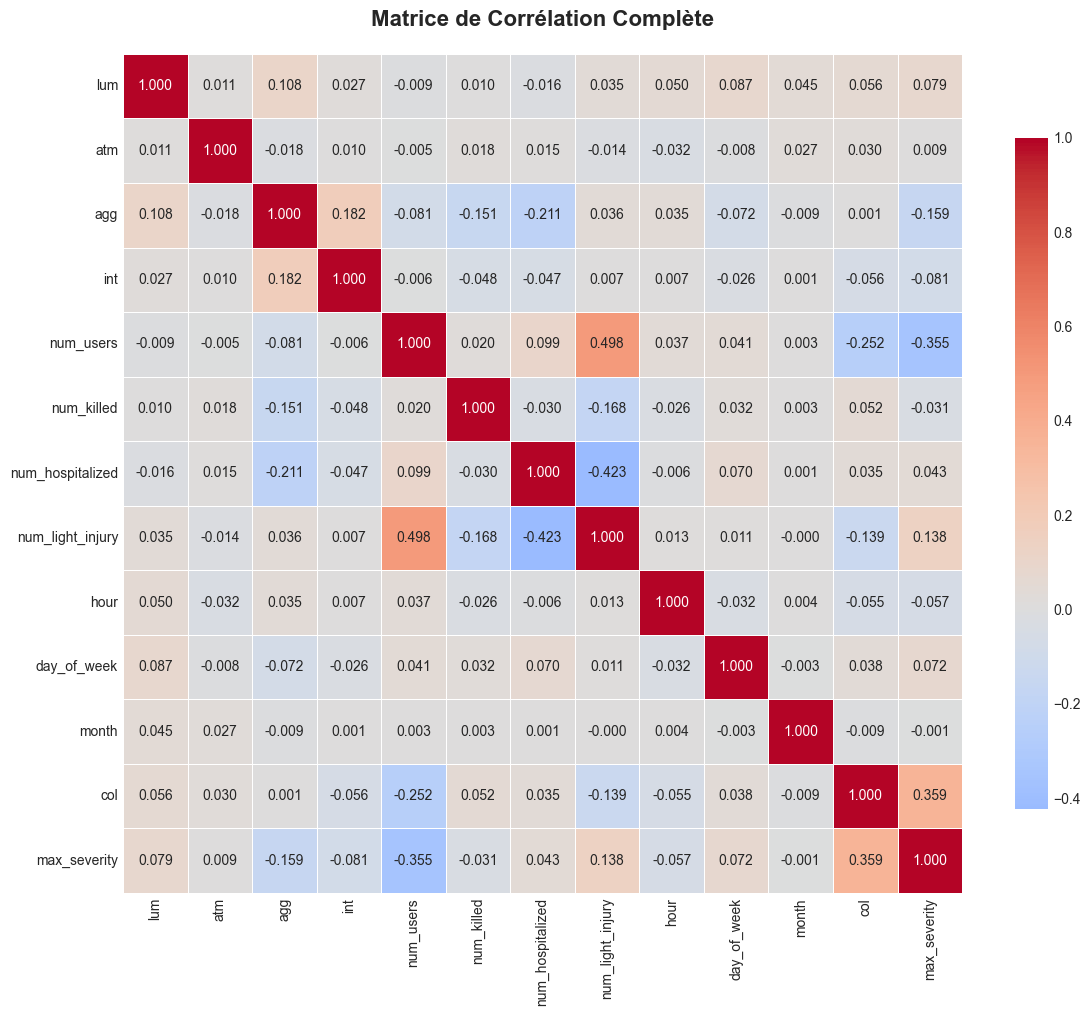


Generating collision type correlations...


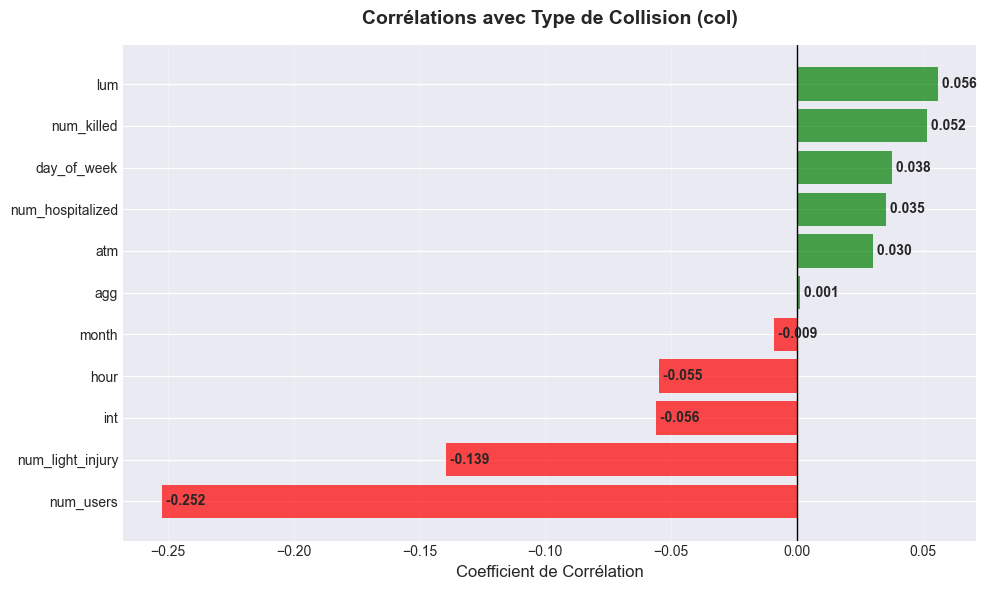


Generating severity correlations...


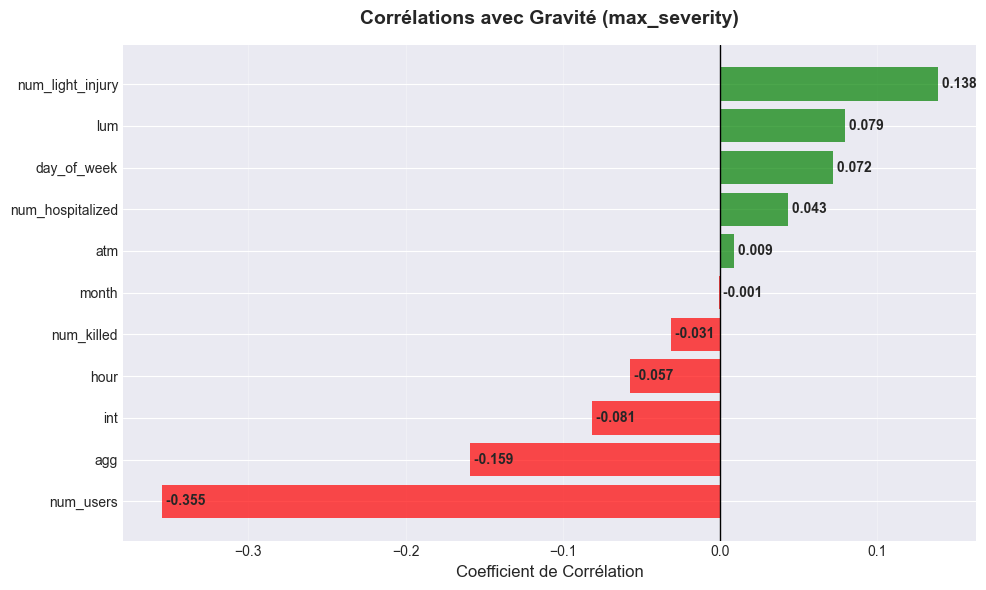


Generating combined importance scores...


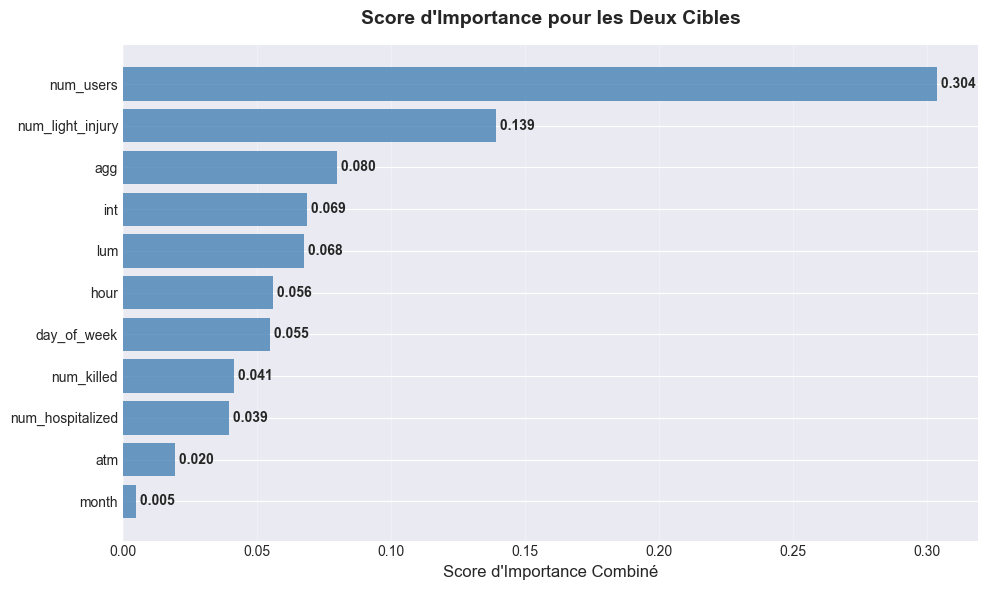


✓ Saved correlation_analysis.png

FEATURE IMPORTANCE SCORES
num_users            | col: -0.2525 | severity: -0.3550 | SCORE: 0.3038
num_light_injury     | col: -0.1394 | severity: +0.1385 | SCORE: 0.1390
agg                  | col: +0.0011 | severity: -0.1588 | SCORE: 0.0800
int                  | col: -0.0560 | severity: -0.0815 | SCORE: 0.0687
lum                  | col: +0.0560 | severity: +0.0793 | SCORE: 0.0676
hour                 | col: -0.0549 | severity: -0.0570 | SCORE: 0.0560
day_of_week          | col: +0.0377 | severity: +0.0720 | SCORE: 0.0548
num_killed           | col: +0.0516 | severity: -0.0312 | SCORE: 0.0414
num_hospitalized     | col: +0.0355 | severity: +0.0433 | SCORE: 0.0394
atm                  | col: +0.0304 | severity: +0.0087 | SCORE: 0.0196
month                | col: -0.0089 | severity: -0.0007 | SCORE: 0.0048

SELECTED FEATURES
Threshold: 0.05

Selected 7 features:
  ✓ num_users            (score: 0.3038)
  ✓ num_light_injury     (score: 0.1390)
  ✓ agg 

In [28]:
print("="*70)
print("FEATURE SELECTION - CORRELATION ANALYSIS")
print("="*70)

# All potential features
all_features = ['lum', 'atm', 'agg', 'int', 'hour', 'day_of_week', 'month',
                'num_users', 'num_killed', 'num_hospitalized', 'num_light_injury']

# Filter to available features (some might not exist yet)
available_features = [f for f in all_features if f in merged_df.columns]
print(f"\nAvailable features for analysis: {available_features}")

# Create temporary time features for correlation analysis
temp_df = merged_df.copy()
if 'hrmn' in temp_df.columns and 'hour' not in temp_df.columns:
    # Extract hour from hrmn
    def extract_hour(hrmn_value):
        if pd.isna(hrmn_value):
            return np.nan
        try:
            if isinstance(hrmn_value, str):
                if ':' in hrmn_value:
                    return int(hrmn_value.split(':')[0])
                else:
                    return int(hrmn_value) // 100
            return int(hrmn_value) // 100
        except:
            return np.nan
    
    temp_df['hour'] = temp_df['hrmn'].apply(extract_hour)
    available_features.append('hour')

# Add day_of_week and month if not present
if 'jour' in temp_df.columns and 'mois' in temp_df.columns and 'an' in temp_df.columns:
    if 'day_of_week' not in temp_df.columns:
        temp_df['date'] = pd.to_datetime(
            temp_df['an'].astype(str) + '-' + 
            temp_df['mois'].astype(str) + '-' + 
            temp_df['jour'].astype(str), 
            errors='coerce'
        )
        temp_df['day_of_week'] = temp_df['date'].dt.dayofweek
        temp_df['month'] = temp_df['mois']
        available_features.extend(['day_of_week', 'month'])

# Update available features
available_features = [f for f in available_features if f in temp_df.columns]

# Prepare correlation dataframe
target_cols = ['col', 'max_severity']
corr_df = temp_df[available_features + target_cols].dropna()

print(f"Dataset for correlation: {len(corr_df):,} rows")
print(f"Features: {available_features}")

# Calculate correlation matrix
corr_matrix = corr_df.corr()

# Extract correlations with targets
col_corr = corr_matrix['col'].drop(target_cols)
sev_corr = corr_matrix['max_severity'].drop(target_cols)

# Calculate combined importance score
combined_importance = pd.DataFrame({
    'feature': col_corr.index,
    'col_corr': col_corr.values,
    'severity_corr': sev_corr.values,
    'abs_col': np.abs(col_corr.values),
    'abs_severity': np.abs(sev_corr.values)
})
combined_importance['combined_score'] = (
    combined_importance['abs_col'] + combined_importance['abs_severity']
) / 2
combined_importance = combined_importance.sort_values('combined_score', ascending=False)


# ============================================================
# VISUALIZATIONS - Each chart separate and clear
# ============================================================

# 1. Full Correlation Heatmap
print("\nGenerating correlation heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, cbar_kws={'shrink': 0.8},
            linewidths=0.5)
plt.title('Matrice de Corrélation Complète', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 2. Correlations with Collision Type
print("\nGenerating collision type correlations...")
plt.figure(figsize=(10, 6))
col_corr_sorted = col_corr.sort_values()
colors = ['red' if x < 0 else 'green' for x in col_corr_sorted.values]
bars = plt.barh(range(len(col_corr_sorted)), col_corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(col_corr_sorted)), col_corr_sorted.index)
plt.xlabel('Coefficient de Corrélation', fontsize=12)
plt.title('Corrélations avec Type de Collision (col)', fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
# Add value labels
for i, v in enumerate(col_corr_sorted.values):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Correlations with Severity
print("\nGenerating severity correlations...")
plt.figure(figsize=(10, 6))
sev_corr_sorted = sev_corr.sort_values()
colors = ['red' if x < 0 else 'green' for x in sev_corr_sorted.values]
bars = plt.barh(range(len(sev_corr_sorted)), sev_corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(sev_corr_sorted)), sev_corr_sorted.index)
plt.xlabel('Coefficient de Corrélation', fontsize=12)
plt.title('Corrélations avec Gravité (max_severity)', fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
# Add value labels
for i, v in enumerate(sev_corr_sorted.values):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Combined Importance Score
print("\nGenerating combined importance scores...")
plt.figure(figsize=(10, 6))
combined_plot = combined_importance.set_index('feature')['combined_score'].sort_values()
bars = plt.barh(range(len(combined_plot)), combined_plot.values, color='steelblue', alpha=0.8)
plt.yticks(range(len(combined_plot)), combined_plot.index)
plt.xlabel('Score d\'Importance Combiné', fontsize=12)
plt.title('Score d\'Importance pour les Deux Cibles', fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3)
# Add value labels
for i, v in enumerate(combined_plot.values):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Save correlation analysis
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Matrice de Corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.close()
print("\n✓ Saved correlation_analysis.png")

# Print results
print("\n" + "="*70)
print("FEATURE IMPORTANCE SCORES")
print("="*70)
for idx, row in combined_importance.iterrows():
    print(f"{row['feature']:20s} | col: {row['col_corr']:+.4f} | "
          f"severity: {row['severity_corr']:+.4f} | SCORE: {row['combined_score']:.4f}")

# Select features with threshold
THRESHOLD = 0.05
selected_features = combined_importance[
    combined_importance['combined_score'] > THRESHOLD
]['feature'].tolist()

if len(selected_features) < 3:
    print(f"\n⚠ Only {len(selected_features)} features above threshold {THRESHOLD}")
    print("  Using top 5 features instead")
    selected_features = combined_importance.head(5)['feature'].tolist()

print("\n" + "="*70)
print("SELECTED FEATURES")
print("="*70)
print(f"Threshold: {THRESHOLD}")
print(f"\nSelected {len(selected_features)} features:")
for feat in selected_features:
    score = combined_importance[combined_importance['feature'] == feat]['combined_score'].values[0]
    print(f"  ✓ {feat:20s} (score: {score:.4f})")

# Store for later use
SELECTED_FEATURES = selected_features
print(f"\n✓ Feature selection complete: {SELECTED_FEATURES}")

---
## 6. Outlier Detection (Détection des Valeurs Aberrantes)

Identify problematic values in selected features:
- Missing values (NaN)
- Invalid codes (-1, 0 where not expected)
- Out-of-range values


OUTLIER DETECTION

Outlier Summary:
         feature  nan_count  nan_pct  neg_one_count  neg_one_pct  zero_count  zero_pct  total_issues
             col         19 0.001727           1536     0.139653           0  0.000000          1555
    max_severity          0 0.000000            116     0.010547           0  0.000000           116
             lum          0 0.000000              7     0.000636           0  0.000000             7
             int          0 0.000000              7     0.000636         107  0.009728             7
             agg          0 0.000000              0     0.000000           0  0.000000             0
       num_users          0 0.000000              0     0.000000           0  0.000000             0
num_light_injury          0 0.000000              0     0.000000      388815 35.351060             0


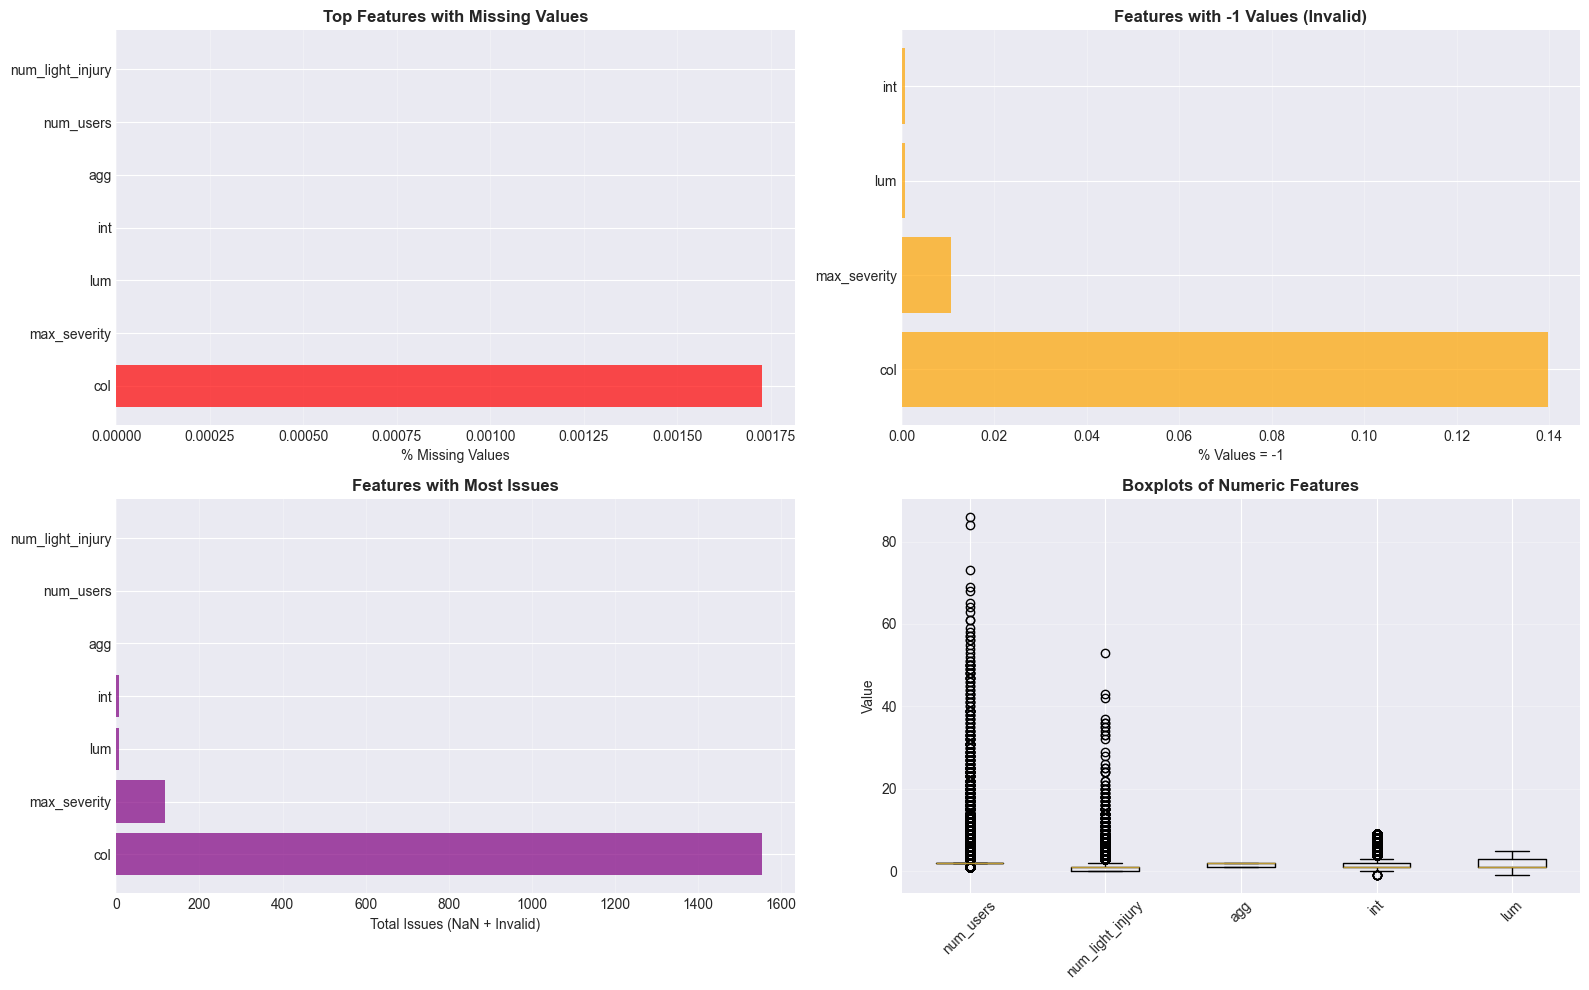


✓ Outlier detection complete


In [29]:
print("="*70)
print("OUTLIER DETECTION")
print("="*70)

# Analyze selected features + targets
features_to_check = SELECTED_FEATURES + ['col', 'max_severity']

outlier_summary = []

for col in features_to_check:
    if col not in merged_df.columns:
        continue
    
    total = len(merged_df)
    nan_count = merged_df[col].isna().sum()
    neg_one_count = (merged_df[col] == -1).sum()
    zero_count = (merged_df[col] == 0).sum()
    
    # Calculate percentages
    nan_pct = (nan_count / total) * 100
    neg_one_pct = (neg_one_count / total) * 100
    zero_pct = (zero_count / total) * 100
    
    outlier_summary.append({
        'feature': col,
        'nan_count': nan_count,
        'nan_pct': nan_pct,
        'neg_one_count': neg_one_count,
        'neg_one_pct': neg_one_pct,
        'zero_count': zero_count,
        'zero_pct': zero_pct,
        'total_issues': nan_count + neg_one_count
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('total_issues', ascending=False)

print("\nOutlier Summary:")
print(outlier_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Missing values
ax = axes[0, 0]
top_missing = outlier_df.nlargest(10, 'nan_pct')
ax.barh(top_missing['feature'], top_missing['nan_pct'], color='red', alpha=0.7)
ax.set_xlabel('% Missing Values')
ax.set_title('Top Features with Missing Values', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 2. -1 values
ax = axes[0, 1]
top_neg = outlier_df[outlier_df['neg_one_pct'] > 0].nlargest(10, 'neg_one_pct')
if len(top_neg) > 0:
    ax.barh(top_neg['feature'], top_neg['neg_one_pct'], color='orange', alpha=0.7)
ax.set_xlabel('% Values = -1')
ax.set_title('Features with -1 Values (Invalid)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Total issues
ax = axes[1, 0]
top_issues = outlier_df.nlargest(10, 'total_issues')
ax.barh(top_issues['feature'], top_issues['total_issues'], color='purple', alpha=0.7)
ax.set_xlabel('Total Issues (NaN + Invalid)')
ax.set_title('Features with Most Issues', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 4. Boxplots for numeric features
ax = axes[1, 1]
numeric_features = [f for f in SELECTED_FEATURES if f in merged_df.columns and 
                    merged_df[f].dtype in ['int64', 'float64']][:5]
if numeric_features:
    data_for_box = [merged_df[f].dropna() for f in numeric_features]
    ax.boxplot(data_for_box, labels=numeric_features)
    ax.set_title('Boxplots of Numeric Features', fontweight='bold')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Outlier detection complete")

---
## 7. Data Cleaning

Clean data based on outlier analysis:
1. Remove unnecessary columns
2. Handle -1 values (replace with mode)
3. Handle missing values (replace with mode or 0)
4. Remove duplicates


In [30]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the dataset based on specified requirements.
    
    Changes:
    - Remove columns: 'Unnamed: 0', 'adr', 'gps', 'source_file'
    - Fill missing 'atm' with mode
    - Fill missing 'col' with mode
    - Fill missing 'lat' and 'long' with mode
    - Remove duplicate rows
    - Keep 'com' (municipality) for geographic analysis
    """
    df_clean = df.copy()
    
    print("="*70)
    print("DATA CLEANING")
    print("="*70)
    print(f"Initial shape: {df_clean.shape}")
    
    # 1. Remove specified columns
    columns_to_remove = ['Unnamed: 0', 'adr', 'gps', 'source_file']
    existing_cols = [col for col in columns_to_remove if col in df_clean.columns]
    
    if existing_cols:
        df_clean = df_clean.drop(columns=existing_cols)
        print(f"\nRemoved columns: {existing_cols}")
    
    # 2. Fill missing values with mode
    # Fill 'atm' (atmospheric conditions)
    if 'atm' in df_clean.columns and df_clean['atm'].isna().sum() > 0:
        atm_mode = df_clean['atm'].mode()[0]
        atm_missing = df_clean['atm'].isna().sum()
        df_clean['atm'] = df_clean['atm'].fillna(atm_mode)
        print(f"Filled {atm_missing} missing values in 'atm' with mode: {atm_mode}")
    
    # Fill 'col' (collision type)
    if 'col' in df_clean.columns and df_clean['col'].isna().sum() > 0:
        col_mode = df_clean['col'].mode()[0]
        col_missing = df_clean['col'].isna().sum()
        df_clean['col'] = df_clean['col'].fillna(col_mode)
        print(f"Filled {col_missing} missing values in 'col' with mode: {col_mode}")
    
    # Fill 'lat' (latitude)
    if 'lat' in df_clean.columns and df_clean['lat'].isna().sum() > 0:
        lat_mode = df_clean['lat'].mode()[0]
        lat_missing = df_clean['lat'].isna().sum()
        df_clean['lat'] = df_clean['lat'].fillna(lat_mode)
        print(f"Filled {lat_missing} missing values in 'lat' with mode: {lat_mode}")
    
    # Fill 'long' (longitude)
    if 'long' in df_clean.columns and df_clean['long'].isna().sum() > 0:
        long_mode = df_clean['long'].mode()[0]
        long_missing = df_clean['long'].isna().sum()
        df_clean['long'] = df_clean['long'].fillna(long_mode)
        print(f"Filled {long_missing} missing values in 'long' with mode: {long_mode}")
    
    # 3. Remove duplicate rows
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = initial_rows - len(df_clean)
    
    if duplicates_removed > 0:
        print(f"\nRemoved {duplicates_removed:,} duplicate rows")
    else:
        print(f"\nNo duplicate rows found")
    
    print(f"\nCleaned dataset shape: {df_clean.shape[0]:,} rows, {df_clean.shape[1]} columns")
    print(f"- Keeping `com` (municipality) for potential geographic analysis")
    print(f"- Keeping `lat`/`long` for future mapping features (filled with mode)")
    
    return df_clean

# Clean the data
cleaned_df = clean_data(merged_df)
print("\n✓ Data cleaning complete")

DATA CLEANING
Initial shape: (1099868, 23)

Removed columns: ['Unnamed: 0', 'adr', 'gps', 'source_file']
Filled 66 missing values in 'atm' with mode: 1.0
Filled 19 missing values in 'col' with mode: 6.0
Filled 446157 missing values in 'lat' with mode: 0.0
Filled 446161 missing values in 'long' with mode: 0.0

No duplicate rows found

Cleaned dataset shape: 1,099,868 rows, 19 columns
- Keeping `com` (municipality) for potential geographic analysis
- Keeping `lat`/`long` for future mapping features (filled with mode)

✓ Data cleaning complete


---
## 8. Feature Engineering

Extract time-based features from the data:
- Hour and minute from hrmn
- Day of week from date
- Month from date


In [31]:
def extract_time_features(hrmn_value):
    """Extract hour and minute from hrmn field."""
    if pd.isna(hrmn_value):
        return np.nan, np.nan
    
    try:
        # Handle 'HH:MM' format
        if isinstance(hrmn_value, str) and ':' in hrmn_value:
            parts = hrmn_value.split(':')
            return int(parts[0]), int(parts[1])
        
        # Handle HHMM integer format
        hrmn_int = int(hrmn_value)
        hour = hrmn_int // 100
        minute = hrmn_int % 100
        return hour, minute
    except:
        return np.nan, np.nan

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Engineer time-based features."""
    df_feat = df.copy()
    
    print("="*70)
    print("FEATURE ENGINEERING")
    print("="*70)
    
    # Extract hour and minute from hrmn
    if 'hrmn' in df_feat.columns:
        time_features = df_feat['hrmn'].apply(extract_time_features)
        df_feat['hour'] = time_features.apply(lambda x: x[0])
        df_feat['minute'] = time_features.apply(lambda x: x[1])
        print("✓ Extracted hour and minute from hrmn")
    
    # Create date and extract day_of_week
    if all(col in df_feat.columns for col in ['an', 'mois', 'jour']):
        df_feat['date'] = pd.to_datetime(
            df_feat['an'].astype(str) + '-' + 
            df_feat['mois'].astype(str) + '-' + 
            df_feat['jour'].astype(str),
            errors='coerce'
        )
        df_feat['day_of_week'] = df_feat['date'].dt.dayofweek
        df_feat['month'] = df_feat['mois']

        # Convert 'an' to full 4-digit year
        if 'an' in df_feat.columns:
            df_feat['year'] = df_feat['an'].apply(
                lambda x: int(x) + 2000 if pd.notna(x) and int(x) < 100 else int(x) if pd.notna(x) else np.nan
            )
            print("✓ Converted 'an' to full 4-digit 'year'")
        print("✓ Extracted day_of_week and month from date")
    
    # Fill any NaN in engineered features
    if 'hour' in df_feat.columns:
        df_feat['hour'] = df_feat['hour'].fillna(df_feat['hour'].mode()[0])
    if 'day_of_week' in df_feat.columns:
        df_feat['day_of_week'] = df_feat['day_of_week'].fillna(df_feat['day_of_week'].mode()[0])
    if 'month' in df_feat.columns:
        df_feat['month'] = df_feat['month'].fillna(df_feat['month'].mode()[0])
    
    print(f"\nFinal shape: {df_feat.shape}")
    return df_feat

# Engineer features
featured_df = engineer_features(cleaned_df)
print("\n✓ Feature engineering complete")

FEATURE ENGINEERING
✓ Extracted hour and minute from hrmn
✓ Converted 'an' to full 4-digit 'year'
✓ Extracted day_of_week and month from date

Final shape: (1099868, 25)

✓ Feature engineering complete


---
## 9. Categorical Encoding

Verify and encode categorical variables.
Most variables are already numeric codes, so we just need to ensure correct types.


In [32]:
def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Encode categorical variables."""
    df_enc = df.copy()
    
    print("="*70)
    print("CATEGORICAL ENCODING")
    print("="*70)
    
    # Categorical columns that should be integers
    cat_cols = ['lum', 'atm', 'agg', 'int', 'col', 'max_severity', 
                'hour', 'day_of_week', 'month']
    
    for col in cat_cols:
        if col in df_enc.columns:
            # Convert to Int64 (nullable integer)
            df_enc[col] = df_enc[col].astype('Int64')
            print(f"✓ {col}: Converted to Int64")
    
    print(f"\nFinal dtypes:")
    print(df_enc[cat_cols].dtypes)
    
    return df_enc

# Encode categoricals
encoded_df = encode_categoricals(featured_df)
print("\n✓ Categorical encoding complete")

CATEGORICAL ENCODING
✓ lum: Converted to Int64
✓ atm: Converted to Int64
✓ agg: Converted to Int64
✓ int: Converted to Int64
✓ col: Converted to Int64
✓ max_severity: Converted to Int64
✓ hour: Converted to Int64
✓ day_of_week: Converted to Int64
✓ month: Converted to Int64

Final dtypes:
lum             Int64
atm             Int64
agg             Int64
int             Int64
col             Int64
max_severity    Int64
hour            Int64
day_of_week     Int64
month           Int64
dtype: object

✓ Categorical encoding complete


---
## 10. Export Cleaned Data

Export two versions:
1. **cleaned_accidents.csv** - Full dataset for Streamlit dashboard
2. **model_ready.csv** - Selected features + targets for ML models


In [33]:
print("="*70)
print("EXPORTING DATA")
print("="*70)

# Export 1: Full cleaned dataset for dashboard

# Ensure year column exists (convert from 'an' if needed)
if 'year' not in encoded_df.columns and 'an' in encoded_df.columns:
    encoded_df['year'] = encoded_df['an'].apply(
        lambda x: int(x) + 2000 if pd.notna(x) and int(x) < 100 else int(x) if pd.notna(x) else np.nan
    )

output_path_1 = 'data/cleaned_accidents.csv'
encoded_df.to_csv(output_path_1, index=False)
print(f"\n✓ Exported: {output_path_1}")
print(f"  Shape: {encoded_df.shape}")
print(f"  Columns: {list(encoded_df.columns)}")

# Export 2: Model-ready dataset (selected features + targets)
model_features = [f for f in SELECTED_FEATURES if f in encoded_df.columns]
model_cols = model_features + ['col', 'max_severity']
model_df = encoded_df[model_cols].copy()

output_path_2 = 'data/model_ready.csv'
model_df.to_csv(output_path_2, index=False)
print(f"\n✓ Exported: {output_path_2}")
print(f"  Shape: {model_df.shape}")
print(f"  Features: {model_features}")
print(f"  Targets: ['col', 'max_severity']")

print("\n" + "="*70)
print("PREPROCESSING COMPLETE!")
print("="*70)
print("\nNext steps:")
print("  1. Run model comparison: python models/compare_multitarget_models.py")
print("  2. Launch dashboard: streamlit run app.py")

EXPORTING DATA

✓ Exported: data/cleaned_accidents.csv
  Shape: (1099868, 25)
  Columns: ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'num_users', 'num_killed', 'num_hospitalized', 'num_light_injury', 'max_severity', 'hour', 'minute', 'date', 'day_of_week', 'month', 'year']

✓ Exported: data/model_ready.csv
  Shape: (1099868, 9)
  Features: ['num_users', 'num_light_injury', 'agg', 'int', 'lum', 'hour', 'day_of_week']
  Targets: ['col', 'max_severity']

PREPROCESSING COMPLETE!

Next steps:
  1. Run model comparison: python models/compare_multitarget_models.py
  2. Launch dashboard: streamlit run app.py


---
## 11. Exploratory Data Analysis (Optional)

Quick visualization of key patterns in the cleaned data.
This section is optional but useful for understanding the data before modeling.


EXPLORATORY DATA ANALYSIS


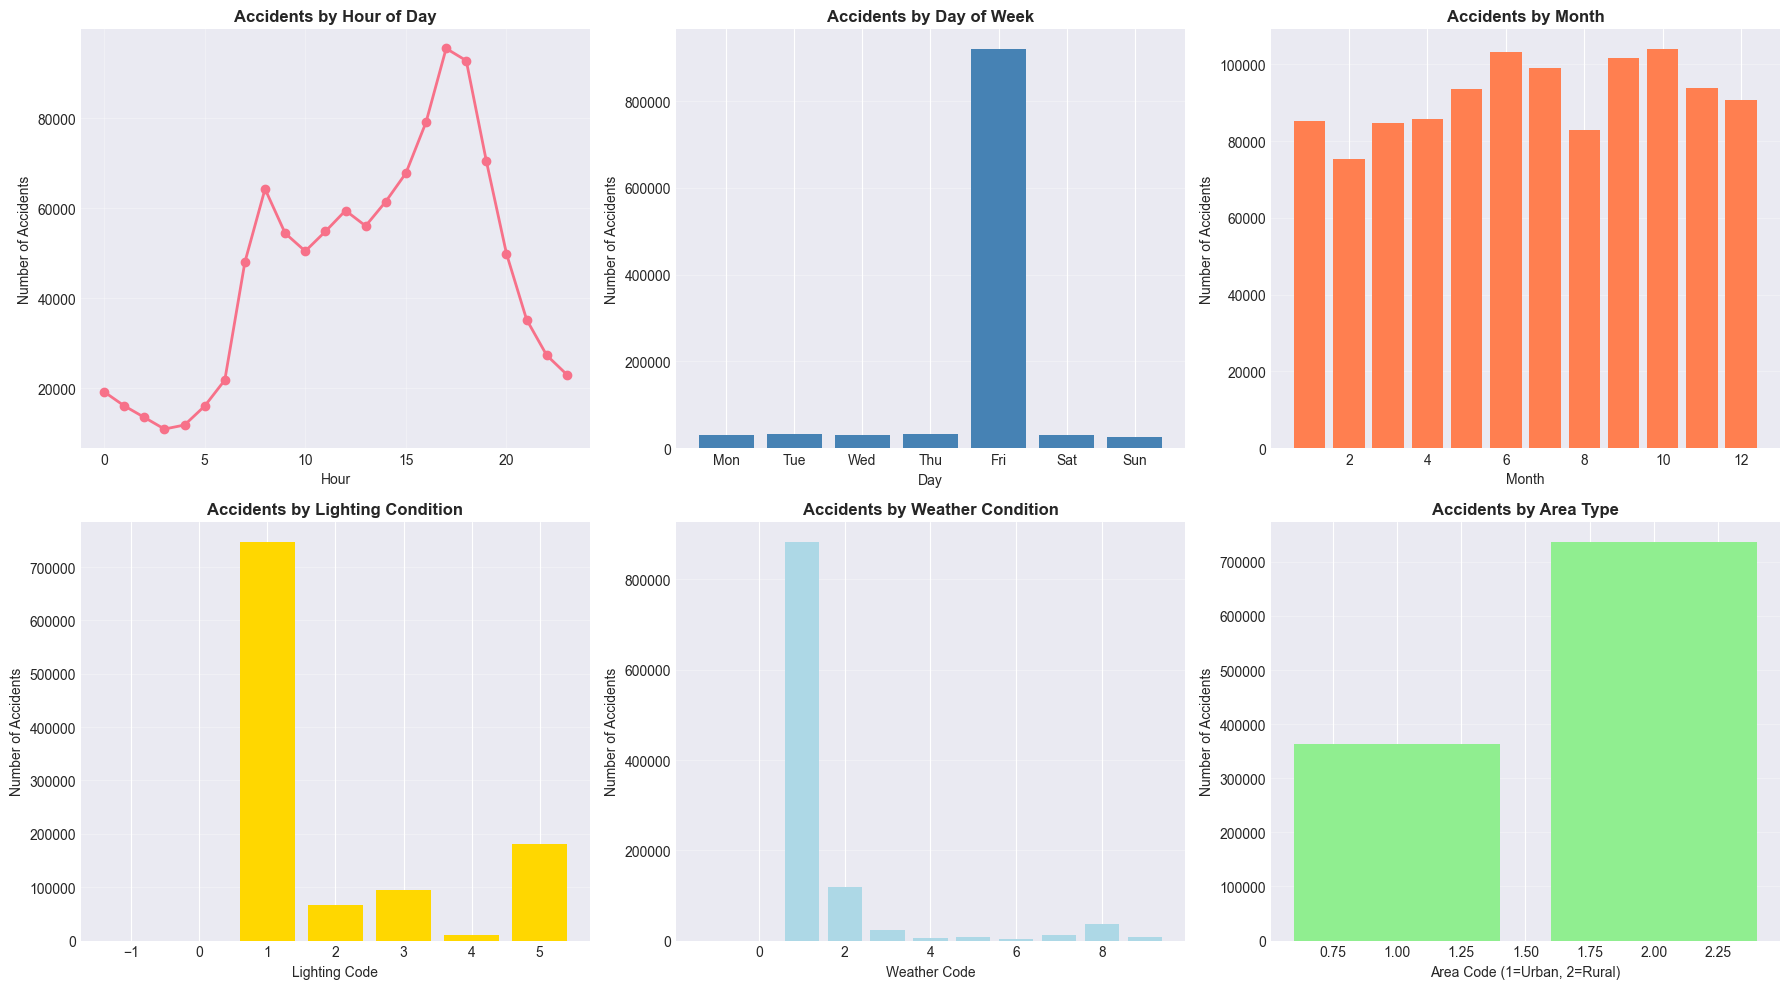


✓ EDA complete


In [34]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accidents by hour
ax = axes[0, 0]
if 'hour' in encoded_df.columns:
    hour_counts = encoded_df['hour'].value_counts().sort_index()
    ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2)
    ax.set_title('Accidents by Hour of Day', fontweight='bold')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Accidents')
    ax.grid(alpha=0.3)

# 2. Accidents by day of week
ax = axes[0, 1]
if 'day_of_week' in encoded_df.columns:
    dow_counts = encoded_df['day_of_week'].value_counts().sort_index()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax.bar(range(len(dow_counts)), dow_counts.values, color='steelblue')
    ax.set_title('Accidents by Day of Week', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of Accidents')
    ax.set_xticks(range(7))
    ax.set_xticklabels(days)
    ax.grid(axis='y', alpha=0.3)

# 3. Accidents by month
ax = axes[0, 2]
if 'month' in encoded_df.columns:
    month_counts = encoded_df['month'].value_counts().sort_index()
    ax.bar(month_counts.index, month_counts.values, color='coral')
    ax.set_title('Accidents by Month', fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Accidents')
    ax.grid(axis='y', alpha=0.3)

# 4. Lighting conditions
ax = axes[1, 0]
if 'lum' in encoded_df.columns:
    lum_counts = encoded_df['lum'].value_counts().sort_index()
    ax.bar(lum_counts.index, lum_counts.values, color='gold')
    ax.set_title('Accidents by Lighting Condition', fontweight='bold')
    ax.set_xlabel('Lighting Code')
    ax.set_ylabel('Number of Accidents')
    ax.grid(axis='y', alpha=0.3)

# 5. Weather conditions
ax = axes[1, 1]
if 'atm' in encoded_df.columns:
    atm_counts = encoded_df['atm'].value_counts().sort_index()
    ax.bar(atm_counts.index, atm_counts.values, color='lightblue')
    ax.set_title('Accidents by Weather Condition', fontweight='bold')
    ax.set_xlabel('Weather Code')
    ax.set_ylabel('Number of Accidents')
    ax.grid(axis='y', alpha=0.3)

# 6. Area type
ax = axes[1, 2]
if 'agg' in encoded_df.columns:
    agg_counts = encoded_df['agg'].value_counts().sort_index()
    ax.bar(agg_counts.index, agg_counts.values, color='lightgreen')
    ax.set_title('Accidents by Area Type', fontweight='bold')
    ax.set_xlabel('Area Code (1=Urban, 2=Rural)')
    ax.set_ylabel('Number of Accidents')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ EDA complete")

---
## 12. Summary

### ✅ Completed Steps
1. ✓ Loaded and merged accident data
2. ✓ Identified two targets: col and max_severity
3. ✓ Selected features based on correlation analysis
4. ✓ Detected outliers and problematic values
5. ✓ Cleaned data (removed columns, handled missing values)
6. ✓ Engineered time-based features
7. ✓ Encoded categorical variables
8. ✓ Exported cleaned data

### 📊 Outputs
- `data/cleaned_accidents.csv` - For dashboard
- `data/model_ready.csv` - For ML models (selected features only)
- `correlation_analysis.png` - Feature correlation visualization

### 🎯 Selected Features
The features were automatically selected based on correlation with both targets.
Check the output of cell 6 (Feature Selection) to see which features were chosen.

### 🚀 Next Steps
1. **Train models**: Run `python models/compare_multitarget_models.py`
2. **View dashboard**: Run `streamlit run app.py`
3. **Review results**: Check `RESULTS_SUMMARY.md`
